In [1]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [2]:
# lib
import os
import gc
import random
import math
import time

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader, Dataset
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')

#import warnings
#warnings.filterwarnings("ignore")

from fastprogress import master_bar, progress_bar
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

if not os.path.exists('models1'):
    os.mkdir('models1')


def seed_everything(seed=777):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True


SEED = 777
seed_everything(SEED)

torch.__version__

'1.7.0'

In [3]:
data_path = '../input/lish-moa/'

In [4]:
def get_logger(filename='log', save=True):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    
    if save:
        handler2 = FileHandler(filename=f"{filename}.log")
        handler2.setFormatter(Formatter("%(message)s"))  
        logger.addHandler(handler2)
    return logger

logger = get_logger(nb_name[:-6])
logger.info(f'file_name: {nb_name[:-6]}')
logger.info(f'Time: {time.ctime()}')
logger.info(f'Set seed: {SEED}')

file_name: 01_baseline-opt-apollo
Time: Mon Nov 16 05:08:51 2020
Set seed: 777


# load df

In [5]:
# load df
# train_df
trn_feature = pd.read_csv(data_path + 'train_features.csv')
print(trn_feature.shape)

# train_df_target
trn_tar_df = pd.read_csv(data_path + 'train_targets_scored.csv')
print(trn_tar_df.shape)

# test_df
test_df = pd.read_csv(data_path + 'test_features.csv')
print(test_df.shape)

# sub_df
sub_df = pd.read_csv(data_path + 'sample_submission.csv')
print(sub_df.shape)

# label column keys
y_keys = list(trn_tar_df.keys())[1:];

# numerical col
genes = [col for col in trn_feature.columns if col.startswith('g-')]
cells = [col for col in trn_feature.columns if col.startswith('c-')]

# catgoriacal col
cat_col = ['cp_time', 'cp_dose']

(23814, 876)
(23814, 207)
(3982, 876)
(3982, 207)


In [6]:
# create df without ctl_vehicle in cp_type
trn_df = trn_feature.merge(trn_tar_df, on='sig_id')
trn_df = trn_df[trn_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
test_df = test_df[test_df.cp_type !='ctl_vehicle'].reset_index(drop=True)
print(trn_df.shape, test_df.shape)
trn_df.sample(20)

(21948, 1082) (3624, 876)


,sig_id,cp_type,cp_time,cp_dose,g-0,g-1,g-2,g-3,g-4,g-5,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
14261,id_a6a4f3626,trt_cp,24,D2,-0.3265,0.1577,-0.3381,0.1789,0.2595,0.7117,...,0,0,0,0,0,0,0,0,0,0
14266,id_a6b456ebb,trt_cp,24,D1,-0.7239,0.0713,0.2250,0.5864,2.6280,-0.4762,...,0,0,0,0,0,0,0,0,0,0
5119,id_3bd739795,trt_cp,24,D1,0.5283,1.2350,2.7150,-0.0206,0.5865,0.2824,...,0,0,0,0,0,0,0,0,0,0
692,id_07b7426b2,trt_cp,24,D1,-0.2856,-0.6573,1.8890,-0.3083,-0.5899,0.5369,...,0,0,0,0,0,0,0,0,0,0
6833,id_4fbf1ada4,trt_cp,72,D2,0.9492,-0.5027,-0.0934,-2.2830,-0.1903,0.0230,...,0,0,0,0,0,0,0,0,0,0
7051,id_52620ac73,trt_cp,24,D1,-0.4717,-0.2592,-0.5129,0.0462,0.5863,-0.6585,...,0,0,0,0,0,0,0,0,0,0
13131,id_995a3b2d4,trt_cp,48,D1,2.4190,-1.1380,-0.4596,-0.1602,2.5480,1.5230,...,0,0,0,0,0,0,0,0,0,0
2435,id_1c33757b3,trt_cp,24,D1,-0.0171,-0.0432,-0.4036,-0.6486,-0.7183,-0.5947,...,0,0,0,0,0,0,0,0,0,0
10021,id_7514b50fb,trt_cp,48,D1,0.5772,0.8006,1.5080,-0.8161,-0.1879,-0.1965,...,0,0,0,0,0,0,0,0,0,0
13768,id_a0ad27715,trt_cp,48,D2,0.2120,0.2485,1.0300,-1.0730,-0.0180,-1.7210,...,0,0,0,0,0,0,0,0,0,0


# cv

In [7]:
# kfolds index
folds = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
for n, (trn_idx, val_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):
    print(trn_idx, val_idx)

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)


[    0     1     2 ... 21945 21946 21947] [    3    15    21 ... 21939 21942 21944]
[    1     2     3 ... 21944 21945 21947] [    0     4     7 ... 21934 21936 21946]
[    0     2     3 ... 21945 21946 21947] [    1    14    18 ... 21928 21940 21943]
[    0     1     2 ... 21944 21946 21947] [    8     9    10 ... 21920 21932 21945]
[    0     1     3 ... 21944 21945 21946] [    2     5     6 ... 21937 21941 21947]


# dataset

In [8]:
class TrainDataset(Dataset):
    def __init__(self, df, features_col, labels_col):
        self.features = torch.FloatTensor(df[features_col].values).to(device)
        self.labels = torch.tensor(df[labels_col].values).float().to(device)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx]
        y = self.labels[idx]

        return x, y


class TestDataset(Dataset):
    def __init__(self, df, features_col):
        self.features = torch.FloatTensor(df[features_col].values)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        x = self.features[idx].to(device)

        return x

In [9]:
cat_features = ['cp_time', 'cp_dose']
feature_cols = genes + cells + cat_features


def cate2num(df):
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 1, 72: 2})
    df['cp_dose'] = df['cp_dose'].map({'D1': 1, 'D2': 0})
    return df


trn_df = cate2num(trn_df)
test_df = cate2num(test_df)

In [10]:
# debug ds, dl
trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, y_keys)
test_dataset = TestDataset(test_df, feature_cols)

trn_loader = DataLoader(trn_dataset,
                        batch_size=32,
                        shuffle=True,
                        drop_last=True)
test_loader = DataLoader(test_dataset,
                         batch_size=32,
                         shuffle=False,
                         drop_last=False)

for xs, ys in trn_loader: 
    print(xs.shape, ys.shape)
    break
for xs in test_loader: 
    print(xs.shape)
    break

torch.Size([32, 874]) torch.Size([32, 206])
torch.Size([32, 874])


# model

In [11]:
class CFG:
    max_grad_norm = 1000
    hidden_size = 256
    dropout = 0.5
    lr = 3e-3
    wd = 1e-6
    bs = 32
    epochs = 30
    smooth = 0.0005
    feature_cols = feature_cols
    target_cols = y_keys
    optimizer = optim.Adam
    scheduler = None 

In [12]:
class MLP(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.h1 = nn.Sequential(
            nn.Linear(len(cfg.feature_cols), cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size), 
            nn.Dropout(cfg.dropout))
        
        self.h2 = nn.Sequential(
            nn.Linear(cfg.hidden_size, cfg.hidden_size),
            nn.Hardswish(inplace=True),
            nn.BatchNorm1d(cfg.hidden_size),
            nn.Dropout(cfg.dropout),
        )
        self.h3 = nn.Linear(cfg.hidden_size, len(cfg.target_cols))

    def forward(self, x):
        x = self.h1(x)
        x = self.h2(x)
        return self.h3(x)

In [13]:
def compute_metric(preds, ys):
    esp = 1e-15
    preds = np.clip(preds, esp, 1 - esp)
    score = -np.mean(np.mean(
        ys * np.log(preds + esp) + (1 - ys) * np.log(1 - preds + esp), axis=1),
                     axis=0)
    return score


def smoothing_critirion(smooth=0.0):
    assert 0 <= smooth < 1, 'smooth not in range'

    def smoothing(criterion):
        def warp(preds, ys):
            with torch.no_grad():
                ys = ys * (1.0 - smooth) + 0.5 * smooth
            return criterion(preds, ys)

        return warp

    return smoothing


@smoothing_critirion(smooth=CFG.smooth)
def criterion(preds, ys):
    return F.binary_cross_entropy_with_logits(preds, ys)

In [15]:
class Apollo(Optimizer):
    r"""Implements Atom algorithm.
        Arguments:
            params (iterable): iterable of parameters to optimize or dicts defining
                parameter groups
            lr (float): learning rate
            beta (float, optional): coefficient used for computing
                running averages of gradient (default: 0.9)
            eps (float, optional): term added to the denominator to improve
                numerical stability (default: 1e-4)
            warmup (int, optional): number of warmup steps (default: 0)
            init_lr (float, optional): initial learning rate for warmup (default: 0.01)
            weight_decay (float, optional): weight decay coefficient (default: 0)
        """

    def __init__(self, params, lr, beta=0.9, eps=1e-4, warmup=100, init_lr=0.01, weight_decay=0):
        if not 0.0 < lr:
            raise ValueError("Invalid learning rate value: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= beta < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(beta))
        if not 0.0 <= weight_decay:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if not 0.0 <= warmup:
            raise ValueError("Invalid warmup updates: {}".format(warmup))
        if not 0.0 <= init_lr <= 1.0:
            raise ValueError("Invalid initial learning rate: {}".format(init_lr))

        defaults = dict(lr=lr, beta=beta, eps=eps, warmup=warmup,
                        init_lr=init_lr, base_lr=lr, weight_decay=weight_decay)
        super(Apollo, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(Apollo, self).__setstate__(state)

    @torch.no_grad()
    def step(self, closure=None):
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None:
                    continue

                state = self.state[p]

                # State initialization
                if len(state) == 0:
                    state['step'] = 0
                    # Exponential moving average of gradient values
                    state['exp_avg_grad'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Exponential moving average of squared gradient values
                    state['approx_hessian'] = torch.zeros_like(p, memory_format=torch.preserve_format)
                    # Previous update direction
                    state['update'] = torch.zeros_like(p, memory_format=torch.preserve_format)

                # Calculate current lr
                if state['step'] < group['warmup']:
                    curr_lr = (group['base_lr'] - group['init_lr']) * state['step'] / group['warmup'] + group['init_lr']
                else:
                    curr_lr = group['lr']

                # Perform optimization step
                grad = p.grad
                if grad.is_sparse:
                    raise RuntimeError('Atom does not support sparse gradients.')

                # Perform step weight decay
                if group['weight_decay'] != 0:
                    grad = grad.add(p, alpha=group['weight_decay'])

                beta = group['beta']
                exp_avg_grad = state['exp_avg_grad']
                B = state['approx_hessian']
                d_p = state['update']

                state['step'] += 1
                bias_correction = 1 - beta ** state['step']
                alpha = (1 - beta) / bias_correction

                # Update the running average grad
                delta_grad = grad - exp_avg_grad
                exp_avg_grad.add_(delta_grad, alpha=alpha)

                denom = d_p.norm(p=4).add(group['eps'])
                d_p.div_(denom)
                v_sq = d_p.mul(d_p)
                delta = delta_grad.div_(denom).mul_(d_p).sum().mul(-alpha) - B.mul(v_sq).sum()

                # Update B
                B.addcmul_(v_sq, delta)

                # calc direction of parameter updates
                denom = B.abs().clamp_(min=1)
                d_p.copy_(exp_avg_grad.div(denom))

                p.add_(d_p, alpha=-curr_lr)

        return loss

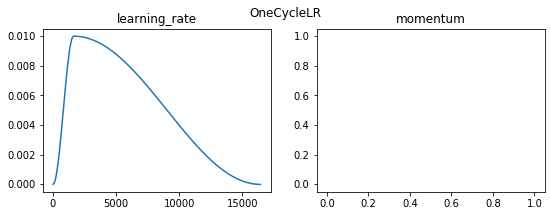

In [18]:
# show_learning_rate_scheduler
#%%capture --no-display
optim_param = {'lr': CFG.lr, 'weight_decay': CFG.wd}
CFG.optimizer = Apollo
CFG.optim_param = optim_param

scheduler_param = {
    'pct_start': 0.1,
    'div_factor': 1e3,
    'max_lr': 1e-2,
    'epochs': CFG.epochs,
    'pct_start':0.1,
    'final_div_factor':10000.0,
    'steps_per_epoch': len(trn_loader),
    'cycle_momentum': False
}
CFG.scheduler = optim.lr_scheduler.OneCycleLR
CFG.scheduler_param = scheduler_param


cfg = CFG
model = MLP(cfg).to(device)
optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)

def show_learning_rate_scheduler():
    lrs = []
    moms = []
    if scheduler.__class__.__name__ == 'OneCycleLR':
        step = cfg.epochs* len(trn_loader)
    else:
        step = cfg.epochs
    
    for i in range(step):
        optimizer.step()
        lrs.append(scheduler.optimizer.param_groups[0]['lr'])
        #moms.append(scheduler.optimizer.param_groups[0]['betas'][0])
        scheduler.step()

    plt.figure(figsize=(9, 3))
    plt.suptitle(scheduler.__class__.__name__)
    plt.subplot(121)
    plt.title('learning_rate')
    plt.plot(lrs)
    plt.subplot(122)
    plt.title('momentum')
    plt.plot(moms)


show_learning_rate_scheduler()

# train

In [19]:
def trn_fn(trn_loader, model, optimizer, scheduler, mb, history):

    running_loss = 0.0
    running_metric = 0.0
    m = 0

    model.train()

    trn_tqdm = progress_bar(trn_loader, total=int(len(trn_loader)), parent=mb)
    for i, (xs, ys) in enumerate(trn_tqdm):
        batch_size = len(xs)
        m += batch_size

        # forward, backward
        optimizer.zero_grad()
        preds = model(xs)
        loss = criterion(preds, ys)
        loss.backward()

        # clip grad
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(),
                                                   CFG.max_grad_norm)
        optimizer.step()
        if scheduler.__class__.__name__ == 'OneCycleLR':
            history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
            scheduler.step() 

        # metric
        metric = compute_metric(preds.sigmoid().detach().cpu().numpy(), 
                                ys.detach().cpu().numpy())
        

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size

        # set commet on child progressbar
        mb.child.comment = (f'loss={loss.item():.4f}, ' f'metric={metric:.4f}')
    
    # step if lr scheduler not onecycle
    if scheduler.__class__.__name__ != 'OneCycleLR':
        history['lrs'].append(scheduler.optimizer.param_groups[0]['lr'])
        scheduler.step()    
        
    return running_loss / m, running_metric / m


def val_fn(val_loader, model, mb):

    running_loss = 0.0
    running_metric = 0.0
    m = 0
    val_preds = []

    model.eval()
    
    val_tqdm = progress_bar(val_loader, total=int(len(val_loader)), parent=mb)
    for i, (xs, ys) in enumerate(val_tqdm):

        batch_size = len(xs)
        m += batch_size

        model.eval()

        # loss
        with torch.no_grad():
            preds = model(xs)
        loss = criterion(preds, ys)
        
        # metric
        preds = preds.sigmoid()
        metric = compute_metric(preds.detach().cpu().numpy(),
                                ys.detach().cpu().numpy())

        # to record
        running_loss += loss.item() * batch_size
        running_metric += metric * batch_size
        val_preds.append(preds.detach().cpu().numpy())

        # set commet on child progressbar
        mb.child.comment = (f'val_loss={loss.item():.4f}, '
                            f'val_metric={metric:.4f}')
        
    val_preds = np.concatenate(val_preds)
    return running_loss / m, running_metric / m, val_preds


def infer_fn(test_loader, model):

    model.eval()
    preds = []

    for i, xs in enumerate(test_loader):

        with torch.no_grad():
            pred = model(xs)
        
        pred = pred.sigmoid()
        preds.append(pred.detach().cpu().numpy())

    preds = np.concatenate(preds)

    return preds


def plot_history(history, fold_num=0):
    
    fig = plt.figure(figsize=(16, 3))
    fig.subplots_adjust(top=0.8)
    plt.suptitle(f'fold{fold_num}')
    
    # metrics
    plt.subplot(131)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_metrics'], 'C0', label='train')
    plt.plot(history['val_metrics'], 'C1', label='val')
    plt.title(f'Metric')
    plt.legend()
    plt.ylabel("Metric") 
    plt.xlabel("Epoch")
    
    # loss
    plt.subplot(132)
    plt.ylim(0.01, 0.03)
    plt.plot(history['trn_losses'], 'C0', label='train')
    plt.plot(history['val_losses'], 'C1', label='val')
    plt.title(f'Loss')
    plt.legend()
    plt.ylabel("Loss") 
    plt.xlabel("Epoch")
    
    # lr
    plt.subplot(133)
    plt.plot(history['lrs'][1:], 'C0', label='lr')
    plt.title(f'Learning rate')
    plt.ylabel("Loss") 
    if history['lrs'] == 'OneCycleLR':
        plt.xlabel("Iteration")    
    else:
        plt.xlabel("Epoch")
    
    plt.show()

In [20]:
def run_single_nn(cfg,
                  trn_df,
                  test_df,
                  fold_idx,
                  feature_cols,
                  target_cols,
                  fold_num=0):
    
    # init
    best_loss = np.inf
    history = {
        'losses': [],
        'trn_losses': [],
        'trn_metrics': [],
        'val_losses': [],
        'val_metrics': [],
        'lrs': [],
    }
    mb = master_bar(range(1, cfg.epochs + 1))
    mb.write(('epoch', 'train loss', 'train metric', 'val loss', 'val metric',
              'time'),
             table=True)

    # loader
    trn_idx, val_idx = fold_idx
    trn_dataset = TrainDataset(trn_df.iloc[trn_idx], feature_cols, target_cols)
    val_dataset = TrainDataset(trn_df.iloc[val_idx], feature_cols, target_cols)
    trn_loader = DataLoader(trn_dataset,
                            batch_size=cfg.bs,
                            shuffle=True,
                            drop_last=True)
    val_loader = DataLoader(val_dataset,
                            batch_size=cfg.bs,
                            shuffle=False,
                            drop_last=False)

    # model
    model = MLP(cfg).to(device)
    optimizer = cfg.optimizer(model.parameters(), **cfg.optim_param)
    scheduler = cfg.scheduler(optimizer, **cfg.scheduler_param)
    history['lrs'].append(scheduler.__class__.__name__)

    # train & validate
    for epoch in mb:
        start_time = time.time()
        trn_loss, trn_metric = trn_fn(trn_loader, 
                                      model, 
                                      optimizer, 
                                      scheduler,
                                      mb, 
                                      history)
        val_loss, val_metric, val_preds = val_fn(val_loader, model, mb)

        # checkpoint
        if val_metric < best_loss:
            logger.info(f'epoch{epoch} save best model... {val_metric}')
            best_loss = val_metric
            oof = np.zeros((len(trn_df), len(cfg.target_cols)))
            oof[val_idx] = val_preds
            torch.save(model.state_dict(), f"fold{fold_num}_.pth")

        # calculate time
        end_time = time.time()
        m, s = divmod(end_time - start_time, 60)

        # record
        history['trn_losses'].append(trn_loss)
        history['trn_metrics'].append(trn_metric)
        history['val_losses'].append(val_loss)
        history['val_metrics'].append(val_metric)
        mb.write((f'{epoch}', f'{trn_loss:.6f}', f'{trn_metric:.10f}',
                  f'{val_loss:.6f}', f'{val_metric:.10f}', f'{m:.0f}:{s:.0f}'),
                 table=True)

    score = compute_metric(oof[val_idx],
                           trn_df.iloc[val_idx][target_cols].values)
    logger.info(f"fold{fold_num} score: {score}")
    plot_history(history, fold_num)

    # predictions
    test_dataset = TestDataset(test_df, feature_cols)
    test_loader = DataLoader(test_dataset,
                             batch_size=cfg.bs,
                             shuffle=False,
                             drop_last=False)

    model = MLP(cfg)
    model.load_state_dict(torch.load(f"fold{fold_num}_.pth"))
    model.to(device)
    predictions = infer_fn(test_loader, model)

    # del
    torch.cuda.empty_cache()

    return oof, predictions


def run_kfold_nn(cfg, trn_df, test_df, feature_cols, target_cols, n_fold=5):

    oof = np.zeros((len(trn_df), len(cfg.target_cols)))
    predictions = np.zeros((len(test_df), len(cfg.target_cols)))

    folds = MultilabelStratifiedKFold(n_splits=5,
                                      shuffle=True,
                                      random_state=SEED)
    for fold_num, (fold_idx) in enumerate(folds.split(trn_df, trn_df[y_keys])):

        logger.info(f'fold {fold_num}')
        _oof, _predictions = run_single_nn(cfg,
                                           trn_df,
                                           test_df,
                                           fold_idx,
                                           cfg.feature_cols,
                                           cfg.target_cols,
                                           fold_num=fold_num)
        oof += _oof
        predictions += _predictions / n_fold

    score = compute_metric(oof, trn_df[y_keys].values)
    logger.info(f"CV score: {score}")

    return oof, predictions

C:\Users\utl\anaconda3\lib\site-packages\sklearn\utils\validation.py:71: FutureWarning: Pass shuffle=True, random_state=777 as keyword args. From version 0.25 passing these as positional arguments will result in an error
  FutureWarning)
fold 0


epoch,train loss,train metric,val loss,val metric,time
1,0.765195,0.7651935881,0.713840,0.7138405255,0:13
2,0.761064,0.7610609115,0.706117,0.7061144546,0:12
3,0.751461,0.7514554052,0.695874,0.6958667106,0:12
4,0.738370,0.7383592708,0.684375,0.6843640464,0:12
5,0.725105,0.7250896474,0.676314,0.6762982849,0:12
6,0.711873,0.7118522624,0.662127,0.6621064615,0:12
7,0.697630,0.6976038388,0.650334,0.6503075961,0:12
8,0.684043,0.6840109831,0.637499,0.6374657759,0:12
9,0.668312,0.6682724688,0.621716,0.6216748215,0:12
10,0.651696,0.6516485042,0.604420,0.6043698877,0:11


epoch1 save best model... 0.7138405255413273
epoch2 save best model... 0.7061144545572494
epoch3 save best model... 0.6958667106400318
epoch4 save best model... 0.6843640464313481
epoch5 save best model... 0.6762982849379607
epoch6 save best model... 0.662106461459792
epoch7 save best model... 0.6503075960556847
epoch8 save best model... 0.6374657759090763
epoch9 save best model... 0.6216748214799885
epoch10 save best model... 0.6043698877299837
epoch11 save best model... 0.587444495448762
epoch12 save best model... 0.567496781360044
epoch13 save best model... 0.5470752495839547
epoch14 save best model... 0.5268815515524705
epoch15 save best model... 0.5046670886541553
epoch16 save best model... 0.4807495478481258
epoch17 save best model... 0.4580985066423655
epoch18 save best model... 0.4391425679104746
epoch19 save best model... 0.42189804839653416
epoch20 save best model... 0.40559835140688816
epoch21 save best model... 0.3938828585631212
epoch22 save best model... 0.382956356624807

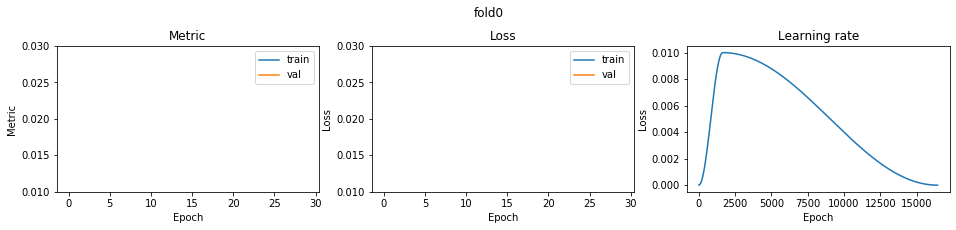

fold 1


epoch,train loss,train metric,val loss,val metric,time
1,0.768192,0.7681920472,0.715162,0.7151644218,0:10
2,0.764126,0.7641248762,0.709608,0.7096077589,0:10
3,0.753890,0.7538856018,0.699501,0.6994961480,0:10
4,0.740798,0.7407885730,0.685347,0.6853376532,0:10
5,0.727287,0.7272725644,0.675178,0.6751630548,0:10
6,0.713158,0.7131381974,0.663147,0.6631273571,0:10
7,0.699100,0.6990743758,0.650445,0.6504187975,0:10
8,0.683377,0.6833447253,0.635793,0.6357589790,0:10
9,0.666880,0.6668395724,0.618673,0.6186310432,0:10
10,0.647989,0.6479391107,0.600973,0.6009205345,0:10


epoch1 save best model... 0.7151644217530696
epoch2 save best model... 0.7096077589435712
epoch3 save best model... 0.6994961479525545
epoch4 save best model... 0.6853376532040959
epoch5 save best model... 0.6751630548383522
epoch6 save best model... 0.663127357105808
epoch7 save best model... 0.6504187974769017
epoch8 save best model... 0.6357589790206696
epoch9 save best model... 0.6186310432038185
epoch10 save best model... 0.6009205345087318
epoch11 save best model... 0.5807048829548667
epoch12 save best model... 0.5585691288680579
epoch13 save best model... 0.5354984600523877
epoch14 save best model... 0.5128107442755883
epoch15 save best model... 0.48661213808354115
epoch16 save best model... 0.4604891337425461
epoch17 save best model... 0.4402879532702449
epoch18 save best model... 0.41915919716088207
epoch19 save best model... 0.3993638374724511
epoch20 save best model... 0.3868194523257475
epoch21 save best model... 0.37265409409361566
epoch22 save best model... 0.359090122173

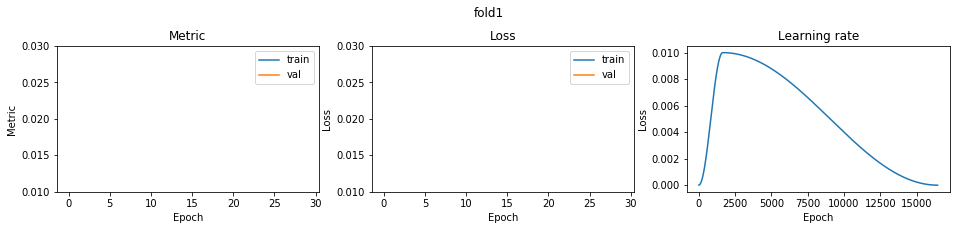

fold 2


epoch,train loss,train metric,val loss,val metric,time
1,0.765978,0.7659767710,0.711319,0.7113193299,0:8
2,0.762283,0.7622809669,0.706568,0.7065664625,0:8
3,0.752190,0.7521841870,0.698945,0.6989386646,0:8
4,0.738397,0.7383863787,0.686367,0.6863560123,0:8
5,0.724898,0.7248831496,0.672439,0.6724228800,0:7
6,0.711569,0.7115490970,0.660261,0.6602384524,0:7
7,0.696790,0.6967635168,0.645993,0.6459632309,0:7
8,0.681370,0.6813364205,0.632344,0.6323083451,0:6
9,0.665679,0.6656382585,0.615764,0.6157198610,0:6
10,0.647180,0.6471301535,0.598276,0.5982221328,0:6


epoch1 save best model... 0.7113193299075579
epoch2 save best model... 0.7065664625406863
epoch3 save best model... 0.6989386646371138
epoch4 save best model... 0.6863560122763493
epoch5 save best model... 0.6724228800415966
epoch6 save best model... 0.6602384523558817
epoch7 save best model... 0.6459632309076861
epoch8 save best model... 0.6323083451191313
epoch9 save best model... 0.6157198610108054
epoch10 save best model... 0.5982221328171925
epoch11 save best model... 0.5787652623248715
epoch12 save best model... 0.5558716395254911
epoch13 save best model... 0.5349934160587156
epoch14 save best model... 0.5092826586808287
epoch15 save best model... 0.481427896210207
epoch16 save best model... 0.462717460157334
epoch17 save best model... 0.436685426071147
epoch18 save best model... 0.4190810065819207
epoch19 save best model... 0.3998862660523291
epoch20 save best model... 0.3857908161307392
epoch21 save best model... 0.3707344134444934
epoch22 save best model... 0.3604243631907763


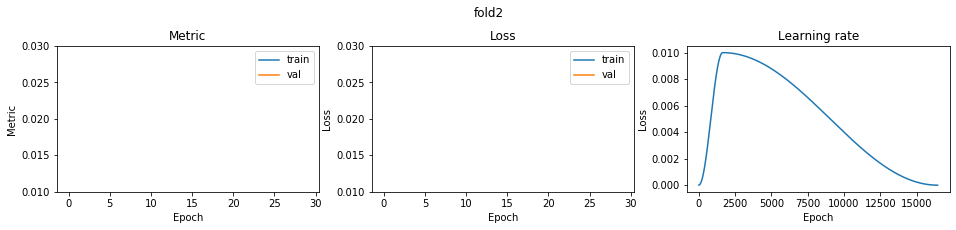

fold 3


epoch,train loss,train metric,val loss,val metric,time
1,0.763477,0.7634751598,0.702844,0.7028407272,0:6
2,0.759148,0.7591449327,0.699363,0.6993575911,0:6
3,0.749176,0.7491691341,0.686953,0.6869433221,0:7
4,0.736336,0.7363254508,0.678440,0.6784261170,0:6
5,0.723462,0.7234462490,0.665835,0.6658154342,0:7
6,0.710513,0.7104923992,0.657030,0.6570055460,0:7
7,0.697137,0.6971102462,0.642871,0.6428402637,0:7
8,0.683043,0.6830105188,0.628863,0.6288251233,0:7
9,0.667654,0.6676146191,0.614566,0.6145207324,0:6
10,0.650736,0.6506878729,0.597608,0.5975540511,0:7


epoch1 save best model... 0.7028407272010838
epoch2 save best model... 0.6993575910500893
epoch3 save best model... 0.6869433220535313
epoch4 save best model... 0.6784261170443749
epoch5 save best model... 0.665815434206048
epoch6 save best model... 0.6570055459789371
epoch7 save best model... 0.6428402637023317
epoch8 save best model... 0.6288251232992272
epoch9 save best model... 0.6145207323626125
epoch10 save best model... 0.5975540511157356
epoch11 save best model... 0.5780566604642499
epoch12 save best model... 0.5576247309226382
epoch13 save best model... 0.5372991584971174
epoch14 save best model... 0.5144569563159639
epoch15 save best model... 0.4925980920264824
epoch16 save best model... 0.4739378752768175
epoch17 save best model... 0.4499206246303263
epoch18 save best model... 0.4316605921079466
epoch19 save best model... 0.413263572606519
epoch20 save best model... 0.39740059055337057
epoch21 save best model... 0.3845364914532403
epoch22 save best model... 0.372959068845236

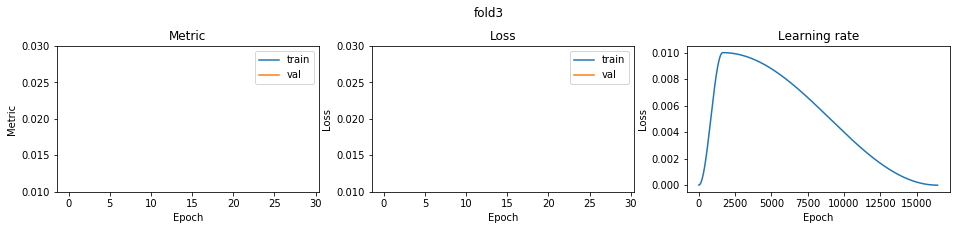

fold 4


epoch,train loss,train metric,val loss,val metric,time
1,0.764676,0.7646741449,0.709315,0.7093137932,0:7
2,0.761065,0.7610622609,0.701277,0.7012719651,0:7
3,0.750803,0.7507971498,0.691753,0.6917444067,0:7
4,0.738203,0.7381925148,0.682256,0.6822426831,0:7
5,0.725042,0.7250265408,0.670394,0.6703762692,0:7
6,0.711264,0.7112426002,0.658289,0.6582659085,0:7
7,0.697568,0.6975410310,0.646031,0.6460014558,0:7
8,0.682611,0.6825774329,0.631005,0.6309686079,0:7
9,0.665972,0.6659306904,0.615535,0.6154904898,0:7
10,0.647925,0.6478746328,0.597986,0.5979315914,0:7


epoch1 save best model... 0.7093137932258207
epoch2 save best model... 0.7012719651018026
epoch3 save best model... 0.6917444067283752
epoch4 save best model... 0.6822426830989081
epoch5 save best model... 0.67037626923081
epoch6 save best model... 0.6582659084595961
epoch7 save best model... 0.6460014558327225
epoch8 save best model... 0.6309686079383711
epoch9 save best model... 0.615490489777237
epoch10 save best model... 0.5979315913891194
epoch11 save best model... 0.5765190012362661
epoch12 save best model... 0.5559378653561065
epoch13 save best model... 0.5338125923771522
epoch14 save best model... 0.5099275818989869
epoch15 save best model... 0.48551736269018914
epoch16 save best model... 0.4615526999183559
epoch17 save best model... 0.4395903854000813
epoch18 save best model... 0.4192576729219432
epoch19 save best model... 0.4011196014142525
epoch20 save best model... 0.3837460900900847
epoch21 save best model... 0.37349030766508845
epoch22 save best model... 0.360408384924869

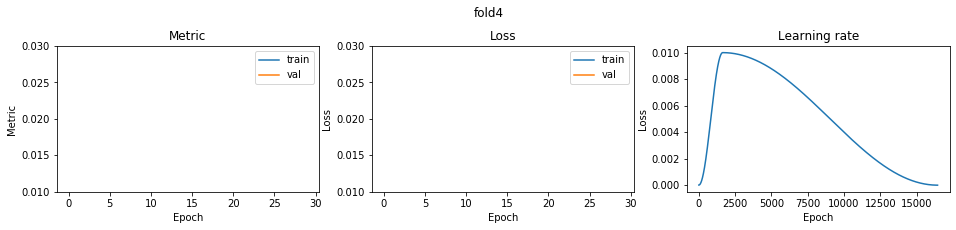

CV score: 0.34096609408874856


In [21]:
oof, predictions = run_kfold_nn(CFG, trn_df, test_df, CFG.feature_cols, CFG.target_cols, n_fold=5)

In [22]:
# OOF score without 'ctl_vehicle'
ys = trn_df[y_keys]
preds = oof

score = compute_metric(preds, ys)
logger.info(f"OOF result: {score}")

OOF result: 0.34096609408874845


In [23]:
ys = trn_df[y_keys]
trn_df[y_keys] = pd.DataFrame(oof)
trn_df[['sig_id'] + y_keys].to_csv('oof.csv', index=False)

test_df[y_keys] = pd.DataFrame(predictions)
test_df[['sig_id'] + y_keys].to_csv('pred.csv', index=False)

In [24]:
# Final result with 'cp_type'=='ctl_vehicle' data
result = trn_tar_df.drop(columns=y_keys).merge(trn_df[['sig_id']+y_keys], on='sig_id', how='left').fillna(0)

ys = trn_tar_df[y_keys].values
preds = result[y_keys].values

score = compute_metric(preds, ys)
logger.info(f"Final result: {score}")

Final result: 0.3142489221911419


In [25]:
sub = sub_df.drop(columns=y_keys).merge(test_df[['sig_id'] + y_keys], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)
sub.head()

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_0004d9e33,0.236188,0.241550,0.226308,0.220146,0.244323,0.237662,0.229330,0.243567,0.221502,...,0.239105,0.230478,0.223977,0.248026,0.246244,0.229939,0.243906,0.216395,0.238999,0.243929
1,id_001897cda,0.205599,0.249584,0.250149,0.222167,0.241396,0.242025,0.248067,0.231178,0.234147,...,0.248219,0.223032,0.246049,0.234619,0.235399,0.242249,0.243971,0.217734,0.233644,0.236660
2,id_002429b5b,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,id_00276f245,0.216514,0.246384,0.237751,0.225520,0.241765,0.236895,0.253653,0.250626,0.228530,...,0.241719,0.219747,0.230516,0.233647,0.250539,0.215858,0.262275,0.231624,0.236706,0.262460
4,id_0027f1083,0.231557,0.250889,0.231638,0.233197,0.237413,0.230323,0.255479,0.247304,0.237261,...,0.243366,0.237434,0.241610,0.219770,0.257456,0.238099,0.252957,0.238506,0.250188,0.245944
